# Importing Libraries

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Initialising Variables

In [2]:
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'E:/Study/Final Year Project/dataset1/'
width=256
height=256
depth=3

# Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        
        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
           
            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Loading images ...
Processing Potato___Early_blight ...
Processing Potato___healthy ...
Processing Potato___Late_blight ...
Image loading completed


# Image Labels uisng LabelBinarizer

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [6]:
#Print the classes
print(label_binarizer.classes_)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [7]:
print(image_labels[0])
print(n_classes)

[1 0 0]
3


#  Normalize i/p in the range  [0-1]

In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [9]:
np_image_list.shape

(552, 256, 256, 3)

In [10]:
np_image_list.ndim

4

In [11]:
np_image_list.min()

0.0

In [12]:
np_image_list.max()

1.0

# Spliting data to train, test data

In [13]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 0) 

Spliting data to train, test


# Using ImageDataGenerator

In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# Applying CNN to Dataset

In [15]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import Adam

In [16]:


model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [18]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("...training network...")

...training network...


In [19]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
13/13 [==============================] - 486s 37s/step - loss: 0.5346 - acc: 0.8742 - val_loss: 1.2964 - val_acc: 0.7628
Epoch 2/25
13/13 [==============================] - 374s 29s/step - loss: 0.2261 - acc: 0.9290 - val_loss: 2.7783 - val_acc: 0.7297
Epoch 3/25
13/13 [==============================] - 368s 28s/step - loss: 0.2099 - acc: 0.9173 - val_loss: 6.1797 - val_acc: 0.5736
Epoch 4/25
13/13 [==============================] - 375s 29s/step - loss: 0.2967 - acc: 0.9153 - val_loss: 5.7575 - val_acc: 0.6156
Epoch 5/25
13/13 [==============================] - 370s 28s/step - loss: 0.1738 - acc: 0.9434 - val_loss: 5.8271 - val_acc: 0.5676
Epoch 6/25
13/13 [==============================] - 367s 28s/step - loss: 0.1603 - acc: 0.9398 - val_loss: 4.0319 - val_acc: 0.6697
Epoch 7/25
13/13 [==============================] - 366s 28s/step - loss: 0.1302 - acc: 0.9573 - val_loss: 4.6871 - val_acc: 0.6306
Epoch 8/25
13/13 [==========

# Plot the train and val curve

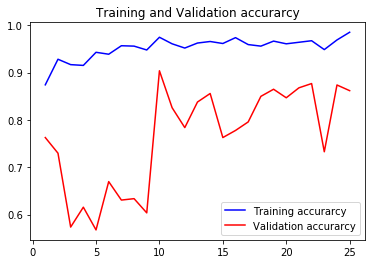

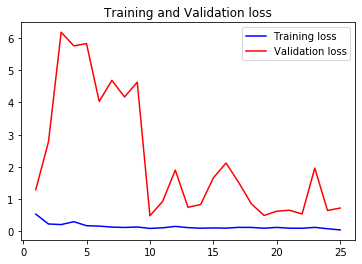

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Model Accuracy

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
111/111 [==============================] - 35s 311ms/step
Test Accuracy: 86.18618717064729


# Save model using Pickle

In [22]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [43]:
import h5py
model.save('trained_model.h5')

# Predictions

In [61]:
#fileobject = open('cnnmodel.pkl', 'rb')
#model = pickle.load(file_object)

imgpath0='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___Early_blight\\pearlyblight.JPG'
imgpath1='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___Late_blight\\plateblight.JPG'
imgpath2='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___healthy\\phealthy.JPG'

imar = convert_image_to_array(imgpath2)
npimagelist = np.array([imar], dtype=np.float16) / 225.0 
PREDICTEDCLASSES2 = model.predict_classes(npimagelist) 
print(PREDICTEDCLASSES2)

#This should print you the category of the prediction.
print (label_binarizer.classes_[PREDICTEDCLASSES2])

[2]
['Potato___healthy']


# Predictions from the H5 file

In [8]:
from keras.models import load_model
import numpy as np
import pickle
import cv2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array

default_image_size = tuple((256, 256))
image_size = 0
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
    
model = load_model('trained_model.h5')
imgpath0='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___Early_blight\\pearlyblight.JPG'
imgpath1='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___Late_blight\\plateblight.JPG'
imgpath2='E:\\Study\\Final Year Project\\dataset1\\Potato\\Potato___healthy\\phealthy.JPG'

imar = convert_image_to_array(imgpath2)
npimagelist = np.array([imar], dtype=np.float16) / 225.0 
PREDICTEDCLASSES2 = model.predict_classes(npimagelist) 
print(PREDICTEDCLASSES2)

#This should print you the category of the prediction.
#print (label_binarizer.classes_[PREDICTEDCLASSES2])
if PREDICTEDCLASSES2==2:
    print("Potato Healthy")
elif PREDICTEDCLASSES2==1:
    print("Potato Late Blight")
else:
    print("Potato Early Blight")

[2]
Potato Healthy
